In [155]:
# Import necessary libraries
import os
import cv2
import json
import torch
import zipfile
import shutil
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
!pip install git+https://github.com/rwightman/efficientdet-pytorch.git
import effdet
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict, DetBenchTrain
import time
import numpy as np
from prettytable import PrettyTable


  Cloning https://github.com/rwightman/efficientdet-pytorch.git to /tmp/pip-req-build-_e_a27e_
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/efficientdet-pytorch.git /tmp/pip-req-build-_e_a27e_
  Resolved https://github.com/rwightman/efficientdet-pytorch.git to commit c6dff775a36cea0bf9b76c58e59f936411c5ce01
  Preparing metadata (setup.py) ... done


### Step 3.1: Download & Load Pretrained Weights

**Homework Instructions:**
1. Download & Load Pretrained Weights.

In this step, I will load the pretrained EfficientDet-D0 model using the right library, verify that the model loads correctly and use the appropriate device, modify the model's head to detect only one class (cups) as the background is already handled.

In [122]:
# Get the default configuration for EfficientDet-D0
config = get_efficientdet_config('tf_efficientdet_d0')

config.num_classes = 1  # Just "cup" class (background is automatically handled)
config.image_size = (512, 512)  # Match the training size

# Create the EfficientDet model with modified config
efficientdet_model = EfficientDet(config, pretrained_backbone=True)

# Create a separate model for training using DetBenchTrain
train_model = DetBenchTrain(efficientdet_model)

# I am using CPU because GPU kept timing out
device = torch.device("cpu")
efficientdet_model = efficientdet_model.to(device)
train_model = train_model.to(device)

# Set both models to evaluation mode initially (will switch to train mode during training)
efficientdet_model.eval()
train_model.eval()

DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))

### Step 3.2: Prepare Custom Dataset (COCO Format Required)

**Instructions from Homework:**
- Prepare Custom Dataset (COCO Format Required) and declare file paths

In this step, I will download the Annotated Cups datase, verify that the dataset is in COCO format, split the dataset into training and validation sets, and organize the dataset into a structure suitable for training.

In [ ]:
# Define paths
zip_path = "./data/annotated-cups.zip"
extract_path = "./data/annotated-cups"  #Please if there is an annotated-cups folder already delete it before running this cell otherwise it will crash, thank you
output_path = "./dataset"

# Create directories
os.makedirs(extract_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# Unzip the file
print("Unzipping dataset.")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify and process the structure
required_folders = ["train", "valid", "test"]
annotation_patterns = ["_annotations.coco.json", "annotations.json"]

print("Processing dataset...")
for split in required_folders:
    split_path = f"{extract_path}/{split}"

    # Find annotation file
    ann_file = f"{split_path}/_annotations.coco.json"

    # Check if the annotation file exists
    if not os.path.exists(ann_file):
        raise FileNotFoundError(f"Could not find annotation file in {split_path}")

    # Create output directories
    os.makedirs(f"{output_path}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_path}/{split}/annotations", exist_ok=True)

    # Copy annotation file with standardized name
    shutil.copy(
        ann_file,
        f"{output_path}/{split}/annotations/instances_{split}.json"
    )

    # Copy images
    img_count = 0
    for item in os.listdir(split_path):
        if item.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.copy(
                f"{split_path}/{item}",
                f"{output_path}/{split}/images/{item}"
            )
            img_count += 1

    print(f"Processed {split}: {img_count} images")

print("\nDataset successfully organized! Check the data set folder")

### Step 3.3: Train the Model on Custom Data

**Instructions from Homework:**
- Train the Model on Custom Data.

In this step, I will define a custom dataset class to load the COCO dataset, set up data loaders for training and validation, train the EfficientDet model on the custom dataset.

Training data

In [123]:
# Set the device
device = torch.device("cpu")

# Paths for training data
train_images_folder = "./dataset/train/images"
train_annotation_file = "./dataset/train/annotations/instances_train.json"

# Load the COCO annotation file
coco_train = COCO(train_annotation_file)

# Get all image IDs
train_image_ids_list = coco_train.getImgIds()

# Create lists to store all images and their targets
train_images_list = []
train_targets_list = []

# Category mapping, this caused issues at first but I analyzed the annotations file carefully
category_mapping = {1: 1}

# Loop through each image ID to load the image and its annotations
for image_index in range(len(train_image_ids_list)):
    current_image_id = train_image_ids_list[image_index]
    image_info = coco_train.loadImgs(current_image_id)[0]
    image_path = os.path.join(train_images_folder, image_info["file_name"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    annotation_ids = coco_train.getAnnIds(imgIds=current_image_id)
    annotations = coco_train.loadAnns(annotation_ids)

    boxes_list = []
    labels_list = []
    areas_list = []

    for annotation in annotations:
        x = annotation["bbox"][0]
        y = annotation["bbox"][1]
        w = annotation["bbox"][2]
        h = annotation["bbox"][3]
        x_max = x + w
        y_max = y + h
        boxes_list.append([x, y, x_max, y_max])
        category_id = annotation["category_id"]
        label = category_mapping[category_id]
        labels_list.append(label)
        area = annotation["area"]
        areas_list.append(area)

    boxes_tensor = torch.as_tensor(boxes_list, dtype=torch.float32)
    labels_tensor = torch.as_tensor(labels_list, dtype=torch.int64)
    areas_tensor = torch.as_tensor(areas_list, dtype=torch.float32)
    image_id_tensor = torch.tensor([current_image_id])

    target_dict = {}
    target_dict["boxes"] = boxes_tensor
    target_dict["labels"] = labels_tensor
    target_dict["area"] = areas_tensor
    target_dict["image_id"] = image_id_tensor
    target_dict["iscrowd"] = torch.zeros((len(annotations),), dtype=torch.int64)

    train_images_list.append(image)
    train_targets_list.append(target_dict)

total_train_images = len(train_images_list)
print("Total training images:", total_train_images)

# Apply training transformations
mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transformed_train_images = []
transformed_train_targets = []

for image_index in range(total_train_images):
    current_image = train_images_list[image_index]
    current_target = train_targets_list[image_index]

    current_boxes = current_target["boxes"].tolist()
    current_labels = current_target["labels"].tolist()

    resized_image = cv2.resize(current_image, (512, 512))

    flip_chance = np.random.random()
    if flip_chance < 0.5:
        flipped_image = cv2.flip(resized_image, 1)
        flipped_boxes = []
        for box in current_boxes:
            x_min = box[0]
            y_min = box[1]
            x_max = box[2]
            y_max = box[3]
            new_x_min = 512 - x_max
            new_x_max = 512 - x_min
            flipped_boxes.append([new_x_min, y_min, new_x_max, y_max])
        current_boxes = flipped_boxes
    else:
        flipped_image = resized_image

    brightness_contrast_chance = np.random.random()
    if brightness_contrast_chance < 0.2:
        brightness = np.random.uniform(-0.2, 0.2)
        contrast = np.random.uniform(0.8, 1.2)
        adjusted_image = flipped_image.astype(np.float32)
        adjusted_image = adjusted_image * contrast + brightness * 255
        adjusted_image = np.clip(adjusted_image, 0, 255)
        adjusted_image = adjusted_image.astype(np.uint8)
    else:
        adjusted_image = flipped_image

    normalized_image = adjusted_image.astype(np.float32) / 255.0
    normalized_image[:,:,0] = (normalized_image[:,:,0] - mean_values[0]) / std_values[0]
    normalized_image[:,:,1] = (normalized_image[:,:,1] - mean_values[1]) / std_values[1]
    normalized_image[:,:,2] = (normalized_image[:,:,2] - mean_values[2]) / std_values[2]

    tensor_image = torch.from_numpy(normalized_image.transpose(2, 0, 1)).float()

    current_target["boxes"] = torch.as_tensor(current_boxes, dtype=torch.float32)
    current_target["labels"] = torch.as_tensor(current_labels, dtype=torch.int64)

    if len(current_target["boxes"]) != len(current_target["labels"]):
        min_length = min(len(current_target["boxes"]), len(current_target["labels"]))
        current_target["boxes"] = current_target["boxes"][:min_length]
        current_target["labels"] = current_target["labels"][:min_length]

    if len(current_target["boxes"]) != len(current_target["labels"]):
        current_target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
        current_target["labels"] = torch.zeros((0,), dtype=torch.int64)

    transformed_train_images.append(tensor_image)
    transformed_train_targets.append(current_target)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total training images: 267


Validation Data

In [124]:
# Load validation data
val_images_folder = "./dataset/valid/images"
val_annotation_file = "./dataset/valid/annotations/instances_valid.json"

coco_val = COCO(val_annotation_file)
val_image_ids_list = coco_val.getImgIds()

val_images_list = []
val_targets_list = []

for image_index in range(len(val_image_ids_list)):
    current_image_id = val_image_ids_list[image_index]
    image_info = coco_val.loadImgs(current_image_id)[0]
    image_path = os.path.join(val_images_folder, image_info["file_name"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    annotation_ids = coco_val.getAnnIds(imgIds=current_image_id)
    annotations = coco_val.loadAnns(annotation_ids)

    boxes_list = []
    labels_list = []
    areas_list = []

    for annotation in annotations:
        x = annotation["bbox"][0]
        y = annotation["bbox"][1]
        w = annotation["bbox"][2]
        h = annotation["bbox"][3]
        x_max = x + w
        y_max = y + h
        boxes_list.append([x, y, x_max, y_max])
        category_id = annotation["category_id"]
        label = category_mapping[category_id]
        labels_list.append(label)
        area = annotation["area"]
        areas_list.append(area)

    boxes_tensor = torch.as_tensor(boxes_list, dtype=torch.float32)
    labels_tensor = torch.as_tensor(labels_list, dtype=torch.int64)
    areas_tensor = torch.as_tensor(areas_list, dtype=torch.float32)
    image_id_tensor = torch.tensor([current_image_id])

    target_dict = {}
    target_dict["boxes"] = boxes_tensor
    target_dict["labels"] = labels_tensor
    target_dict["area"] = areas_tensor
    target_dict["image_id"] = image_id_tensor
    target_dict["iscrowd"] = torch.zeros((len(annotations),), dtype=torch.int64)

    val_images_list.append(image)
    val_targets_list.append(target_dict)

total_val_images = len(val_images_list)
print("Total validation images:", total_val_images)

# Apply validation transformations
# Create lists to store transformed validation images and targets
transformed_val_images = []
transformed_val_targets = []

# Loop through each validation image and target
for image_index in range(total_val_images):
    current_image = val_images_list[image_index]
    current_target = val_targets_list[image_index]

    # Get the bounding boxes and labels
    current_boxes = current_target["boxes"].tolist()
    current_labels = current_target["labels"].tolist()

    # First I will resize the image to 512x512
    resized_image = cv2.resize(current_image, (512, 512))

    # Then normalize the image
    normalized_image = resized_image.astype(np.float32) / 255.0
    normalized_image[:,:,0] = (normalized_image[:,:,0] - mean_values[0]) / std_values[0]
    normalized_image[:,:,1] = (normalized_image[:,:,1] - mean_values[1]) / std_values[1]
    normalized_image[:,:,2] = (normalized_image[:,:,2] - mean_values[2]) / std_values[2]

    # Next is to convert to tensor
    tensor_image = torch.from_numpy(normalized_image.transpose(2, 0, 1)).float()

    # Then update the target
    current_target["boxes"] = torch.as_tensor(current_boxes, dtype=torch.float32)
    current_target["labels"] = torch.as_tensor(current_labels, dtype=torch.int64)

    # This check is to avoid errors
    if len(current_target["boxes"]) != len(current_target["labels"]):
        min_length = min(len(current_target["boxes"]), len(current_target["labels"]))
        current_target["boxes"] = current_target["boxes"][:min_length]
        current_target["labels"] = current_target["labels"][:min_length]

    if len(current_target["boxes"]) != len(current_target["labels"]):
        current_target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
        current_target["labels"] = torch.zeros((0,), dtype=torch.int64)

    # Add to the lists
    transformed_val_images.append(tensor_image)
    transformed_val_targets.append(current_target)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total validation images: 20


### Setting the hyper parameters so I can fine-tune them

Experiment 1: Batch Set = 2, Number of Epochs = 5, Learning Rate = 0.01

In [125]:
# Set the hyper parameters that I will be finetuning
batch_size = 2
num_epochs = 5

# Shuffle the training data
train_indices = list(range(total_train_images))
np.random.shuffle(train_indices)

# Calculate the number of batches
num_train_batches = total_train_images // batch_size
if total_train_images % batch_size != 0:
    num_train_batches = num_train_batches + 1

# Create a list to store all training batches
train_batches = []

# Loop to create batches
for batch_index in range(num_train_batches):
    # Get the start and end indices for this batch
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    if end_index > total_train_images:
        end_index = total_train_images

    # Get the indices for this batch
    batch_indices = train_indices[start_index:end_index]

    # Create lists for this batch
    batch_images = []
    batch_targets = []

    # Loop through the indices to build the batch
    for idx in batch_indices:
        batch_images.append(transformed_train_images[idx])
        batch_targets.append(transformed_train_targets[idx])

    # Add the batch to the list
    train_batches.append((batch_images, batch_targets))

    # Calculate the number of validation batches
    num_val_batches = total_val_images // batch_size
    if total_val_images % batch_size != 0:
        num_val_batches = num_val_batches + 1

    # Create a list to store all validation batches
    val_batches = []

    # Loop to create validation batches
    for batch_index in range(num_val_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        if end_index > total_val_images:
            end_index = total_val_images

        batch_images = []
        batch_targets = []

        for idx in range(start_index, end_index):
            batch_images.append(transformed_val_images[idx])
            batch_targets.append(transformed_val_targets[idx])

        val_batches.append((batch_images, batch_targets))

# Move the model to the device
train_model = train_model.to(device)

# Set up the optimizer, the final optimizer to be fine tuned
optimizer = optim.Adam(train_model.parameters(), lr=0.01)

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    train_model.train()

    # Keep track of the total loss
    total_loss = 0
    num_batches_processed = 0

    # Loop through each batch
    for batch_images, batch_targets in train_batches:
        # Stack the images into a single tensor
        images_tensor = torch.stack(batch_images).to(device)

        # Filter out targets with no annotations
        filtered_targets = []
        for target in batch_targets:
            if len(target["boxes"]) > 0:
                filtered_targets.append(target)

        # If no targets have annotations, skip this batch
        if len(filtered_targets) == 0:
            continue

        # Find the maximum number of boxes in this batch
        max_boxes = 0
        for target in filtered_targets:
            num_boxes = len(target["boxes"])
            if num_boxes > max_boxes:
                max_boxes = num_boxes

        # Pad the bounding boxes and labels to the same size
        padded_bboxes_list = []
        padded_labels_list = []

        for target in filtered_targets:
            current_boxes = target["boxes"]
            current_labels = target["labels"]
            num_boxes = len(current_boxes)

            # Pad boxes
            if num_boxes < max_boxes:
                padding = torch.zeros((max_boxes - num_boxes, 4))
                padded_boxes = torch.cat([current_boxes, padding])
            else:
                padded_boxes = current_boxes

            # Pad labels because I was having issues with the forward pass without doing that data augmentation
            if num_boxes < max_boxes:
                padding = torch.zeros((max_boxes - num_boxes,), dtype=torch.int64)
                padded_labels = torch.cat([current_labels, padding])
            else:
                padded_labels = current_labels

            padded_bboxes_list.append(padded_boxes)
            padded_labels_list.append(padded_labels)

        # Stack the padded boxes and labels
        effdet_bboxes = torch.stack(padded_bboxes_list).to(device)
        effdet_labels = torch.stack(padded_labels_list).to(device)

        # Create the EfficientDet target dictionary
        effdet_targets = {}
        effdet_targets["bbox"] = effdet_bboxes
        effdet_targets["cls"] = effdet_labels
        effdet_targets["img_size"] = torch.tensor([512, 512]).to(device).unsqueeze(0).repeat(len(filtered_targets), 1)
        effdet_targets["img_scale"] = torch.ones(len(filtered_targets)).to(device)

        # Forward pass
        loss_dict = train_model(images_tensor, effdet_targets)

        # Sum the losses
        total_batch_loss = 0
        for loss_value in loss_dict.values():
            total_batch_loss = total_batch_loss + loss_value

        # Backward pass
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        # Add to total loss
        total_loss = total_loss + total_batch_loss.item()
        num_batches_processed = num_batches_processed + 1

    # Calculate average loss
    if num_batches_processed > 0:
        average_loss = total_loss / num_batches_processed
    else:
        average_loss = 0

    print("Epoch", epoch + 1, "of", num_epochs, ", Loss:", average_loss)

Epoch 1 of 5 , Loss: 7.640483815723391
Epoch 2 of 5 , Loss: 6.990950791248634
Epoch 3 of 5 , Loss: 6.917469172780193
Epoch 4 of 5 , Loss: 6.862698610594023
Epoch 5 of 5 , Loss: 6.83099884639925


Experiment 2: Batch Set = 4, Number of Epochs = 10, Learning Rate = 0.0001

In [154]:
# Set the hyper parameters that I will be finetuning
batch_size = 4
num_epochs = 10

# Shuffle the training data
train_indices = list(range(total_train_images))
np.random.shuffle(train_indices)

# Calculate the number of batches
num_train_batches = total_train_images // batch_size
if total_train_images % batch_size != 0:
    num_train_batches = num_train_batches + 1

# Create a list to store all training batches
train_batches = []

# Loop to create batches
for batch_index in range(num_train_batches):
    # Get the start and end indices for this batch
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    if end_index > total_train_images:
        end_index = total_train_images

    # Get the indices for this batch
    batch_indices = train_indices[start_index:end_index]

    # Create lists for this batch
    batch_images = []
    batch_targets = []

    # Loop through the indices to build the batch
    for idx in batch_indices:
        batch_images.append(transformed_train_images[idx])
        batch_targets.append(transformed_train_targets[idx])

    # Add the batch to the list
    train_batches.append((batch_images, batch_targets))

    # Calculate the number of validation batches
    num_val_batches = total_val_images // batch_size
    if total_val_images % batch_size != 0:
        num_val_batches = num_val_batches + 1

    # Create a list to store all validation batches
    val_batches = []

    # Loop to create validation batches
    for batch_index in range(num_val_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        if end_index > total_val_images:
            end_index = total_val_images

        batch_images = []
        batch_targets = []

        for idx in range(start_index, end_index):
            batch_images.append(transformed_val_images[idx])
            batch_targets.append(transformed_val_targets[idx])

        val_batches.append((batch_images, batch_targets))

# Move the model to the device
train_model = train_model.to(device)

# Set up the optimizer, the final optimizer to be fine tuned
optimizer = optim.Adam(train_model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    train_model.train()

    # Keep track of the total loss
    total_loss = 0
    num_batches_processed = 0

    # Loop through each batch
    for batch_images, batch_targets in train_batches:
        # Stack the images into a single tensor
        images_tensor = torch.stack(batch_images).to(device)

        # Filter out targets with no annotations
        filtered_targets = []
        for target in batch_targets:
            if len(target["boxes"]) > 0:
                filtered_targets.append(target)

        # If no targets have annotations, skip this batch
        if len(filtered_targets) == 0:
            continue

        # Find the maximum number of boxes in this batch
        max_boxes = 0
        for target in filtered_targets:
            num_boxes = len(target["boxes"])
            if num_boxes > max_boxes:
                max_boxes = num_boxes

        # Pad the bounding boxes and labels to the same size
        padded_bboxes_list = []
        padded_labels_list = []

        for target in filtered_targets:
            current_boxes = target["boxes"]
            current_labels = target["labels"]
            num_boxes = len(current_boxes)

            # Pad boxes
            if num_boxes < max_boxes:
                padding = torch.zeros((max_boxes - num_boxes, 4))
                padded_boxes = torch.cat([current_boxes, padding])
            else:
                padded_boxes = current_boxes

            # Pad labels because I was having issues with the forward pass without doing that data augmentation
            if num_boxes < max_boxes:
                padding = torch.zeros((max_boxes - num_boxes,), dtype=torch.int64)
                padded_labels = torch.cat([current_labels, padding])
            else:
                padded_labels = current_labels

            padded_bboxes_list.append(padded_boxes)
            padded_labels_list.append(padded_labels)

        # Stack the padded boxes and labels
        effdet_bboxes = torch.stack(padded_bboxes_list).to(device)
        effdet_labels = torch.stack(padded_labels_list).to(device)

        # Create the EfficientDet target dictionary
        effdet_targets = {}
        effdet_targets["bbox"] = effdet_bboxes
        effdet_targets["cls"] = effdet_labels
        effdet_targets["img_size"] = torch.tensor([512, 512]).to(device).unsqueeze(0).repeat(len(filtered_targets), 1)
        effdet_targets["img_scale"] = torch.ones(len(filtered_targets)).to(device)

        # Forward pass
        loss_dict = train_model(images_tensor, effdet_targets)

        # Sum the losses
        total_batch_loss = 0
        for loss_value in loss_dict.values():
            total_batch_loss = total_batch_loss + loss_value

        # Backward pass
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        # Add to total loss
        total_loss = total_loss + total_batch_loss.item()
        num_batches_processed = num_batches_processed + 1

    # Calculate average loss
    if num_batches_processed > 0:
        average_loss = total_loss / num_batches_processed
    else:
        average_loss = 0

    print("Epoch", epoch + 1, "of", num_epochs, ", Loss:", average_loss)

Epoch 1 of 10 , Loss: 7.5751245555593005
Epoch 2 of 10 , Loss: 7.492645165813503
Epoch 3 of 10 , Loss: 7.406165861371738
Epoch 4 of 10 , Loss: 7.323337478424186
Epoch 5 of 10 , Loss: 7.201611173686697
Epoch 6 of 10 , Loss: 6.9651502388626785
Epoch 7 of 10 , Loss: 6.127497641008292
Epoch 8 of 10 , Loss: 5.199864602800625
Epoch 9 of 10 , Loss: 4.854954708867998
Epoch 10 of 10 , Loss: 4.600919876525651


Experiment 3: Batch Set = 4, Number of Epochs = 15, Learning Rate = 0.0005

In [26]:
# Set the hyper parameters that I will be finetuning
batch_size = 4
num_epochs = 15

# Shuffle the training data
train_indices = list(range(total_train_images))
np.random.shuffle(train_indices)

# Calculate the number of batches
num_train_batches = total_train_images // batch_size
if total_train_images % batch_size != 0:
    num_train_batches = num_train_batches + 1

# Create a list to store all training batches
train_batches = []

# Loop to create batches
for batch_index in range(num_train_batches):
    # Get the start and end indices for this batch
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    if end_index > total_train_images:
        end_index = total_train_images

    # Get the indices for this batch
    batch_indices = train_indices[start_index:end_index]

    # Create lists for this batch
    batch_images = []
    batch_targets = []

    # Loop through the indices to build the batch
    for idx in batch_indices:
        batch_images.append(transformed_train_images[idx])
        batch_targets.append(transformed_train_targets[idx])

    # Add the batch to the list
    train_batches.append((batch_images, batch_targets))

    # Calculate the number of validation batches
    num_val_batches = total_val_images // batch_size
    if total_val_images % batch_size != 0:
        num_val_batches = num_val_batches + 1

    # Create a list to store all validation batches
    val_batches = []

    # Loop to create validation batches
    for batch_index in range(num_val_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        if end_index > total_val_images:
            end_index = total_val_images

        batch_images = []
        batch_targets = []

        for idx in range(start_index, end_index):
            batch_images.append(transformed_val_images[idx])
            batch_targets.append(transformed_val_targets[idx])

        val_batches.append((batch_images, batch_targets))

# Move the model to the device
train_model = train_model.to(device)

# Set up the optimizer, the final optimizer to be fine tuned
optimizer = optim.Adam(train_model.parameters(), lr=0.0005)

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    train_model.train()

    # Keep track of the total loss
    total_loss = 0
    num_batches_processed = 0

    # Loop through each batch
    for batch_images, batch_targets in train_batches:
        # Stack the images into a single tensor
        images_tensor = torch.stack(batch_images).to(device)

        # Filter out targets with no annotations
        filtered_targets = []
        for target in batch_targets:
            if len(target["boxes"]) > 0:
                filtered_targets.append(target)

        # If no targets have annotations, skip this batch
        if len(filtered_targets) == 0:
            continue

        # Find the maximum number of boxes in this batch
        max_boxes = 0
        for target in filtered_targets:
            num_boxes = len(target["boxes"])
            if num_boxes > max_boxes:
                max_boxes = num_boxes

        # Pad the bounding boxes and labels to the same size
        padded_bboxes_list = []
        padded_labels_list = []

        for target in filtered_targets:
            current_boxes = target["boxes"]
            current_labels = target["labels"]
            num_boxes = len(current_boxes)

            # Pad boxes
            if num_boxes < max_boxes:
                padding = torch.zeros((max_boxes - num_boxes, 4))
                padded_boxes = torch.cat([current_boxes, padding])
            else:
                padded_boxes = current_boxes

            # Pad labels because I was having issues with the forward pass without doing that data augmentation
            if num_boxes < max_boxes:
                padding = torch.zeros((max_boxes - num_boxes,), dtype=torch.int64)
                padded_labels = torch.cat([current_labels, padding])
            else:
                padded_labels = current_labels

            padded_bboxes_list.append(padded_boxes)
            padded_labels_list.append(padded_labels)

        # Stack the padded boxes and labels
        effdet_bboxes = torch.stack(padded_bboxes_list).to(device)
        effdet_labels = torch.stack(padded_labels_list).to(device)

        # Create the EfficientDet target dictionary
        effdet_targets = {}
        effdet_targets["bbox"] = effdet_bboxes
        effdet_targets["cls"] = effdet_labels
        effdet_targets["img_size"] = torch.tensor([512, 512]).to(device).unsqueeze(0).repeat(len(filtered_targets), 1)
        effdet_targets["img_scale"] = torch.ones(len(filtered_targets)).to(device)

        # Forward pass
        loss_dict = train_model(images_tensor, effdet_targets)

        # Sum the losses
        total_batch_loss = 0
        for loss_value in loss_dict.values():
            total_batch_loss = total_batch_loss + loss_value

        # Backward pass
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        # Add to total loss
        total_loss = total_loss + total_batch_loss.item()
        num_batches_processed = num_batches_processed + 1

    # Calculate average loss
    if num_batches_processed > 0:
        average_loss = total_loss / num_batches_processed
    else:
        average_loss = 0

    print("Epoch", epoch + 1, "of", num_epochs, ", Loss:", average_loss)

NameError: name 'total_train_images' is not defined

### Step 3.5: Evaluate Model Performance

**Instructions from Homework:**
- Evaluate Model Performance.
  - Compute mAP (mean Average Precision) and IoU (Intersection over Union).

In this step, I will evaluate the trained model on the validation set, compute mAP using the COCO evaluation metrics and visualize some detection results to assess detection quality.

Testing Dataset

In [171]:
# Set the device
device = torch.device("cpu")

# Paths for test data
test_images_folder = "./dataset/test/images"
test_annotation_file = "./dataset/test/annotations/instances_test.json"

# Load the COCO annotation file
coco_test = COCO(test_annotation_file)

# Get all image IDs
test_image_ids_list = coco_test.getImgIds()

# Create lists to store all images and their targets
test_images_list = []
test_targets_list = []

# Category mapping
category_mapping = {1: 1}

# Loop through each image ID to load the image and its annotations
for image_index in range(len(test_image_ids_list)):
    current_image_id = test_image_ids_list[image_index]
    image_info = coco_test.loadImgs(current_image_id)[0]
    image_path = os.path.join(test_images_folder, image_info["file_name"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    annotation_ids = coco_test.getAnnIds(imgIds=current_image_id)
    annotations = coco_test.loadAnns(annotation_ids)

    boxes_list = []
    labels_list = []
    areas_list = []

    for annotation in annotations:
        x = annotation["bbox"][0]
        y = annotation["bbox"][1]
        w = annotation["bbox"][2]
        h = annotation["bbox"][3]
        x_max = x + w
        y_max = y + h
        boxes_list.append([x, y, x_max, y_max])
        category_id = annotation["category_id"]
        label = category_mapping[category_id]
        labels_list.append(label)
        area = annotation["area"]
        areas_list.append(area)

    boxes_tensor = torch.as_tensor(boxes_list, dtype=torch.float32)
    labels_tensor = torch.as_tensor(labels_list, dtype=torch.int64)
    areas_tensor = torch.as_tensor(areas_list, dtype=torch.float32)
    image_id_tensor = torch.tensor([current_image_id])

    target_dict = {}
    target_dict["boxes"] = boxes_tensor
    target_dict["labels"] = labels_tensor
    target_dict["area"] = areas_tensor
    target_dict["image_id"] = image_id_tensor
    target_dict["iscrowd"] = torch.zeros((len(annotations),), dtype=torch.int64)

    test_images_list.append(image)
    test_targets_list.append(target_dict)

total_test_images = len(test_images_list)
print("Total test images:", total_test_images)

# Apply test transformations (no data augmentation for test set)
mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transformed_test_images = []
transformed_test_targets = []

for image_index in range(total_test_images):
    current_image = test_images_list[image_index]
    current_target = test_targets_list[image_index]

    current_boxes = current_target["boxes"].tolist()
    current_labels = current_target["labels"].tolist()

    # Resize image to match the training setup
    resized_image = cv2.resize(current_image, (512, 512))

    # Normalize the image (same as training)
    normalized_image = resized_image.astype(np.float32) / 255.0
    normalized_image[:,:,0] = (normalized_image[:,:,0] - mean_values[0]) / std_values[0]
    normalized_image[:,:,1] = (normalized_image[:,:,1] - mean_values[1]) / std_values[1]
    normalized_image[:,:,2] = (normalized_image[:,:,2] - mean_values[2]) / std_values[2]

    tensor_image = torch.from_numpy(normalized_image.transpose(2, 0, 1)).float()

    # Scale the bounding boxes to the resized dimensions
    img_height, img_width = current_image.shape[:2]
    scale_x = 512 / img_width
    scale_y = 512 / img_height
    scaled_boxes = []
    for box in current_boxes:
        x_min = box[0] * scale_x
        y_min = box[1] * scale_y
        x_max = box[2] * scale_x
        y_max = box[3] * scale_y
        scaled_boxes.append([x_min, y_min, x_max, y_max])

    current_target["boxes"] = torch.as_tensor(scaled_boxes, dtype=torch.float32)
    current_target["labels"] = torch.as_tensor(current_labels, dtype=torch.int64)

    transformed_test_images.append(tensor_image)
    transformed_test_targets.append(current_target)

# Create test batches similarly to how I created validation batches
batch_size = 4  # Same as the training batch size
num_test_batches = total_test_images // batch_size
if total_test_images % batch_size != 0:
    num_test_batches += 1

test_batches = []

for batch_index in range(num_test_batches):
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    if end_index > total_test_images:
        end_index = total_test_images

    batch_images = []
    batch_targets = []

    for idx in range(start_index, end_index):
        batch_images.append(transformed_test_images[idx])
        batch_targets.append(transformed_test_targets[idx])

    test_batches.append((batch_images, batch_targets))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total test images: 10


In [217]:
# Evaluation loop
efficientdet_model.eval()  # Set model to evaluation mode

iou_values = []
total_inference_time = 0
total_images_processed = 0
all_precision = []
all_recall = []
coco_results = []

IMAGE_SIZE = 512

for batch_idx, (batch_images, batch_targets) in enumerate(test_batches):
    images_tensor = torch.stack(batch_images).to(device)

    start_time = time.time()
    with torch.no_grad():
        outputs = efficientdet_model(images_tensor)
    end_time = time.time()

    batch_inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    total_inference_time += batch_inference_time

    # Process each image in the batch
    for i in range(len(batch_images)):
        image_idx = batch_idx * batch_size + i
        if image_idx >= total_test_images:
            break

        total_images_processed += 1

        # Extract predictions for this image
        box_outputs = outputs[0]
        class_outputs = outputs[1]

        all_boxes = []
        all_scores = []
        all_labels = []

        for level_idx in range(len(box_outputs)):
            boxes = box_outputs[level_idx][i]
            scores = class_outputs[level_idx][i]

            # Reshape boxes and scores
            boxes = boxes.view(9, -1, boxes.shape[-1])
            boxes = boxes.permute(1, 0, 2).contiguous()
            boxes = boxes.view(-1, 4)

            scores = scores.view(36, -1)
            scores = scores.permute(1, 0).contiguous()
            scores = scores.view(-1, 36)

            scores = torch.softmax(scores, dim=-1)[:, 1]
            labels = torch.ones_like(scores, dtype=torch.long)

            # Assume the raw boxes are in normalized form [0, 1] and scale to image size
            # If the range is different (e.g., [-1, 1]), adjust accordingly
            if boxes.min() >= 0 and boxes.max() <= 1:
                # Already in [0, 1], just scale to image size
                decoded_boxes = boxes * IMAGE_SIZE
            elif boxes.min() >= -1 and boxes.max() <= 1:
                # In [-1, 1], map to [0, 1] then scale
                decoded_boxes = (boxes + 1) / 2 * IMAGE_SIZE
            else:
                # If the range is something else (e.g., [-5, 5]), normalize based on the actual range
                box_range = boxes.max() - boxes.min()
                if box_range > 0:
                    decoded_boxes = (boxes - boxes.min()) / box_range * IMAGE_SIZE
                else:
                    decoded_boxes = boxes  # Fallback if range is zero

            # Clip boxes to image boundaries
            decoded_boxes[:, 0] = torch.clamp(decoded_boxes[:, 0], 0, IMAGE_SIZE)  # x_min
            decoded_boxes[:, 1] = torch.clamp(decoded_boxes[:, 1], 0, IMAGE_SIZE)  # y_min
            decoded_boxes[:, 2] = torch.clamp(decoded_boxes[:, 2], 0, IMAGE_SIZE)  # x_max
            decoded_boxes[:, 3] = torch.clamp(decoded_boxes[:, 3], 0, IMAGE_SIZE)  # y_max

            all_boxes.append(decoded_boxes)
            all_scores.append(scores)
            all_labels.append(labels)

        predicted_boxes = torch.cat(all_boxes, dim=0).cpu().numpy()
        predicted_scores = torch.cat(all_scores, dim=0).cpu().numpy()
        predicted_labels = torch.cat(all_labels, dim=0).cpu().numpy()

        # Ensure all arrays have the same length
        min_length = min(predicted_boxes.shape[0], predicted_scores.shape[0], predicted_labels.shape[0])
        predicted_boxes = predicted_boxes[:min_length]
        predicted_scores = predicted_scores[:min_length]
        predicted_labels = predicted_labels[:min_length]

        # Filter by confidence
        confidence_threshold = 0.05
        #print(predicted_scores)
        keep_indices = predicted_scores > confidence_threshold
        filtered_boxes = predicted_boxes[keep_indices]
        filtered_scores = predicted_scores[keep_indices]
        filtered_labels = predicted_labels[keep_indices]

        # Filter out padded boxes (boxes with all zeros)
        non_padded_indices = []
        for idx, box in enumerate(filtered_boxes):
            # Check if the box has non-zero coordinates (padded boxes have all zeros)
            if not np.all(box == 0):
                non_padded_indices.append(idx)

        filtered_boxes = filtered_boxes[non_padded_indices]
        filtered_scores = filtered_scores[non_padded_indices]
        filtered_labels = filtered_labels[non_padded_indices]

        # Get the image ID for COCO format results
        img_id = test_image_ids_list[image_idx]

        # Prepare COCO format results for mAP calculation
        for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
            x_min, y_min, x_max, y_max = box
            coco_results.append({
                'image_id': img_id,
                'category_id': 1,  # Assuming class 1 for bowls
                'bbox': [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],
                'score': float(score)
            })

        # Calculate IoU, Precision, Recall for this image
        ground_truth_boxes = batch_targets[i]["boxes"].cpu().numpy()
        true_positives = 0
        false_positives = 0
        false_negatives = len(ground_truth_boxes)

        # Keep track of matched ground truth boxes
        matched_gt_indices = set()

        for pred_box in filtered_boxes:
            pred_x_min, pred_y_min, pred_x_max, pred_y_max = pred_box

            best_iou = 0
            best_gt_idx = -1

            for gt_idx, gt_box in enumerate(ground_truth_boxes):
                if gt_idx in matched_gt_indices:
                    continue  # Skip already matched ground truth boxes
                gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_box

                # Calculate intersection
                inter_x_min = max(pred_x_min, gt_x_min)
                inter_y_min = max(pred_y_min, gt_y_min)
                inter_x_max = min(pred_x_max, gt_x_max)
                inter_y_max = min(pred_y_max, gt_y_max)

                if inter_x_max > inter_x_min and inter_y_max > inter_y_min:
                    intersection = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
                else:
                    intersection = 0

                # Calculate union
                pred_area = (pred_x_max - pred_x_min) * (pred_y_max - pred_y_min)
                gt_area = (gt_x_max - gt_x_min) * (gt_y_max - gt_y_min)
                union = pred_area + gt_area - intersection

                if union > 0:
                    iou = intersection / union
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx

            # Append IoU to iou_values if it's non-zero
            if best_iou > 0:
                iou_values.append(best_iou)

            # It is so low because I have really low iou values
            # I have really low iou values bc i am using efficientdet-d0 which is the least powerful variant in efficientdet
            # I had to pick this because of memory constraints
            if best_iou > 0.05:
                true_positives += 1
                false_negatives -= 1
                if best_gt_idx >= 0:
                    matched_gt_indices.add(best_gt_idx)
            else:
                false_positives += 1

        # Calculate precision and recall for this image
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        all_precision.append(precision)
        all_recall.append(recall)

# calculate mAP
def compute_ap(recall, precision):
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])
    i = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[i + 1] - recall[i]) * precision[i + 1])
    return ap

# Calculate average IoU
average_iou = 0  # Default value if no IoU values
if len(iou_values) > 0:
    total_iou = 0
    for value in iou_values:
        total_iou += value
    average_iou = total_iou / len(iou_values)

# Calculate average precision
average_precision = 0  # Default value if no precision values
if len(all_precision) > 0:
    total_precision = 0
    for value in all_precision:
        total_precision += value
    average_precision = total_precision / len(all_precision)

# Calculate average recall
average_recall = 0  # Default value if no recall values
if len(all_recall) > 0:
    total_recall = 0
    for value in all_recall:
        total_recall += value
    average_recall = total_recall / len(all_recall)

# Calculate average inference time
average_inference_time_ms = 0  # Default value if no images processed
if total_images_processed > 0:
    average_inference_time_ms = total_inference_time / total_images_processed

# Calculate FPS
fps = 0  # Default value if no inference time
if average_inference_time_ms > 0:
    fps = 1000 / average_inference_time_ms

# Calculate mAP
map_score = 0  # Default value
if len(all_recall) > 0 and len(all_precision) > 0:
    map_score = compute_ap(all_recall, all_precision)

# Display results in a table
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["mAP", f"{map_score:.4f}"])
table.add_row(["Average IoU", f"{average_iou:.4f}"])
table.add_row(["Precision", f"{average_precision:.4f}"])
table.add_row(["Recall", f"{average_recall:.4f}"])
table.add_row(["Inference Time (ms/img)", f"{average_inference_time_ms:.2f}"])
table.add_row(["FPS", f"{fps:.2f}"])
print(table)

+-------------------------+--------+
|          Metric         | Value  |
+-------------------------+--------+
|           mAP           | 0.0008 |
|       Average IoU       | 0.0026 |
|        Precision        | 0.0007 |
|          Recall         | 0.8083 |
| Inference Time (ms/img) | 556.00 |
|           FPS           |  1.80  |
+-------------------------+--------+


Visual Analysis

In [ ]:

# Visual Analysis: Display predictions and ground truth for an image
def plot_image_with_boxes(image_tensor, predicted_boxes, predicted_scores, ground_truth_boxes, idx):
    # Convert tensor to numpy image
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    # Denormalize
    image_numpy = image_numpy * np.array(std_values) + np.array(mean_values)
    image_numpy = (image_numpy * 255).clip(0, 255).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_numpy)
    ax.set_title(f"Test Image {idx+1}: Object Detection Results")

    # Draw predicted boxes
    for i, box in enumerate(predicted_boxes):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        rect = plt.Rectangle((x_min, y_min), width, height,
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        if i < len(predicted_scores):
            score = predicted_scores[i]
            ax.text(x_min, y_min-5, f"Score: {score:.2f}",
                   color='red', fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.7))

    # Draw ground truth boxes
    for box in ground_truth_boxes:
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        rect = plt.Rectangle((x_min, y_min), width, height,
                            fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='none', edgecolor='red', label='Prediction'),
        Patch(facecolor='none', edgecolor='green', label='Ground Truth')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"detection_test_image_{idx+1}.png", dpi=300, bbox_inches='tight')
    plt.close()

# Display predictions for 1 test image
num_samples = 1
for i in range(num_samples):
    image_tensor = transformed_test_images[i]
    ground_truth_boxes = transformed_test_targets[i]["boxes"].numpy()

    # Get predictions for this image
    with torch.no_grad():
        outputs = efficientdet_model(image_tensor.unsqueeze(0).to(device))

    # Process predictions
    box_outputs = outputs[0]
    class_outputs = outputs[1]

    all_boxes = []
    all_scores = []

    for level_idx in range(len(box_outputs)):
        level_boxes = box_outputs[level_idx][0]
        level_scores = class_outputs[level_idx][0]

        # Reshape
        level_boxes = level_boxes.view(9, -1, level_boxes.shape[-1])
        level_boxes = level_boxes.permute(1, 0, 2).contiguous()
        level_boxes = level_boxes.view(-1, 4)

        level_scores = level_scores.view(36, -1)
        level_scores = level_scores.permute(1, 0).contiguous()
        level_scores = level_scores.view(-1, 36)

        level_scores = torch.softmax(level_scores, dim=-1)[:, 1]

        # Ensure boxes and scores have the same length at each level
        min_length = min(level_boxes.shape[0], level_scores.shape[0])
        level_boxes = level_boxes[:min_length]
        level_scores = level_scores[:min_length]

        # Scale boxes
        level_boxes = (level_boxes + 10) / 20
        level_boxes *= IMAGE_SIZE

        all_boxes.append(level_boxes)
        all_scores.append(level_scores)

    predicted_boxes = torch.cat(all_boxes, dim=0).cpu().numpy()
    predicted_scores = torch.cat(all_scores, dim=0).cpu().numpy()

    # Ensure final arrays have the same length
    min_length = min(predicted_boxes.shape[0], predicted_scores.shape[0])
    predicted_boxes = predicted_boxes[:min_length]
    predicted_scores = predicted_scores[:min_length]

    # Filter by confidence
    threshold = 0.3  # Lower threshold for visualization
    keep_indices = predicted_scores > threshold
    filtered_boxes = predicted_boxes[keep_indices]
    filtered_scores = predicted_scores[keep_indices]

    # Plot results
    plot_image_with_boxes(image_tensor, filtered_boxes, filtered_scores, ground_truth_boxes, i)

print(f"Saved {num_samples} visualization images.")

### Part 2 - Image Segmentation

In [1]:
# Import Libraries for Part 2
# Install all the libraries I need
#!pip install torch torchvision
#!pip install segmentation_models_pytorch
#!pip install transformers
#!pip install opencv-python
#!pip install git+https://github.com/facebookresearch/segment-anything.git
# Download SAM pretrained weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P ./data
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Image Preprocessing

In [4]:
# Select an image containing multiple instances of the object worked on in Homework 2
img_path1 = "./data/1a.png"
img_path2 = "./data/1b.jpg"
img_path3 = "./data/1b.png"
# Load the picture and make it ready for the models
img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)
if img1 is None:
    print("The picture 1 did not load. Check the path again")
else:
    print("The picture 1 has loaded successfully")
if img2 is None:
    print("The picture 2 did not load. Check the path again")
else:
    print("The picture 2 has loaded successfully")
if img3 is None:
    print("The picture 3 did not load. Check the path again")
else:
    print("The picture 3 has loaded successfully")

# Change the picture from BGR to RGB
img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img_rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Make a copy of the picture for showing later
original_img1 = img_rgb1.copy()
original_img2 = img_rgb2.copy()
original_img3 = img_rgb3.copy()

# I need to make the image a tensor for PyTorch models
# First, I will resize the image to 608x608 i used 512 before but unet wasnt working
img_resized1 = cv2.resize(img_rgb1, (608, 608))
img_resized2 = cv2.resize(img_rgb2, (608, 608))
img_resized3 = cv2.resize(img_rgb3, (608, 608))

# Make a transform to change the picture for the models
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Turn the picture into a tensor for PyTorch
img_tensor1 = img_transform(img_resized1).unsqueeze(0)
img_tensor2 = img_transform(img_resized2).unsqueeze(0)
img_tensor3 = img_transform(img_resized3).unsqueeze(0)  # Add batch dimension

The picture 1 has loaded successfully
The picture 2 has loaded successfully
The picture 3 has loaded successfully


### Segmentation Models - Mask R-CNN

In [13]:
# Using Mask R-CNN
# First, I will load the Mask R-CNN model from torchvision
maskrcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# I need to set the model to evaluation mode
maskrcnn_model.eval()
device = torch.device("cpu")
# Move the model to the device
maskrcnn_model = maskrcnn_model.to(device)

# Process each image
img_tensors = [img_tensor1, img_tensor2, img_tensor3]
maskrcnn_final_masks = []

for idx, img_tensor in enumerate(img_tensors, 1):
    img_tensor = img_tensor.to(device)
    # Run the model on the image
    with torch.no_grad():
        maskrcnn_output = maskrcnn_model(img_tensor)

    # Get the masks, labels, and scores
    maskrcnn_predictions = maskrcnn_output[0]
    maskrcnn_masks = maskrcnn_predictions['masks']  # Shape: (num_objects, 1, H, W)
    maskrcnn_labels = maskrcnn_predictions['labels']
    maskrcnn_scores = maskrcnn_predictions['scores']

    # Keep masks with a score greater than 0.03
    good_masks = []
    for i in range(len(maskrcnn_scores)):
        if maskrcnn_scores[i] > 0.03:
            mask = maskrcnn_masks[i, 0].cpu().numpy()
            mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
            # Resize the mask to 608x608
            mask = cv2.resize(mask, (608, 608), interpolation=cv2.INTER_NEAREST)
            # Filter by area
            area = np.sum(mask)
            if area > 300 and area < 6000:
                good_masks.append(mask)
        else:
            print(f"Skipping a mask for image {idx} because score {maskrcnn_scores[i]:.3f} is too low")

    # Combine all good masks into one mask
    if len(good_masks) > 0:
        maskrcnn_final_mask = np.zeros((608, 608), dtype=np.uint8)
        for mask in good_masks:
            maskrcnn_final_mask = maskrcnn_final_mask | mask
    else:
        maskrcnn_final_mask = np.zeros((608, 608), dtype=np.uint8)
        print(f"No good masks from Mask R-CNN for image {idx}")

    maskrcnn_final_masks.append(maskrcnn_final_mask)

maskrcnn_final_mask1, maskrcnn_final_mask2, maskrcnn_final_mask3 = maskrcnn_final_masks

print("I am done with Mask R-CNN.")

I am done with Mask R-CNN.


### Segmentation Model - Unet

In [23]:
# Using U-Net
# Load U-Net model from segmentation_models_pytorch
unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

# Move the model to the device
unet_model = unet_model.to(device)

# Set the model to evaluation mode
unet_model.eval()

# Process each image
unet_final_masks = []
area_ranges = [
    (100, 4000),   # Image 1: mints (widened)
    (5000, 60000), # Image 2: bowls (widened)
    (100, 3000)    # Image 3: servo horns (widened)
]

for idx, (img_tensor, area_range) in enumerate(zip(img_tensors, area_ranges), 1):
    img_tensor = img_tensor.to(device)
    # Run the model on the image
    with torch.no_grad():
        unet_output = unet_model(img_tensor)

    # Get the segmentation mask
    unet_mask = torch.sigmoid(unet_output).squeeze().cpu().numpy()
    unet_final_mask = (unet_mask > 0.5).astype(np.uint8)

    # Apply dilation to connect regions
    kernel = np.ones((5, 5), np.uint8)
    if idx in [1, 3]:  # Images 1 and 3: mints and servo horns
        unet_final_mask = cv2.dilate(unet_final_mask, kernel, iterations=2)  # Increased iterations
    else:  # Image 2: bowls
        unet_final_mask = cv2.dilate(unet_final_mask, kernel, iterations=1)

    # Filter by area
    unet_contours, _ = cv2.findContours(unet_final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_mask = np.zeros_like(unet_final_mask)
    for contour in unet_contours:
        area = cv2.contourArea(contour)
        if area_range[0] < area < area_range[1]:
            cv2.drawContours(filtered_mask, [contour], -1, 1, thickness=cv2.FILLED)
    unet_final_mask = filtered_mask

    unet_final_masks.append(unet_final_mask)

unet_final_mask1, unet_final_mask2, unet_final_mask3 = unet_final_masks

print("I am done with U-Net")

I am done with U-Net


### Segmentation Model - SAM

In [19]:
# Using Segment Anything Model (SAM)

# Load SAM
sam_checkpoint = "./data/sam_vit_b_01ec64.pth"
sam_model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam_model = sam_model.to(device)

# Create a mask generator
sam_mask_generator = SamAutomaticMaskGenerator(
    sam_model,
    points_per_side=32,
    pred_iou_thresh=0.7,  # Lowered from 0.8
    stability_score_thresh=0.85,  # Lowered from 0.9
)

# Process each image
sam_final_masks = []
img_rgb_list = [img_rgb1, img_rgb2, img_rgb3]
area_ranges = [
    (200, 3000),   # Image 1: mints
    (5000, 50000), # Image 2: bowls
    (150, 2000)    # Image 3: servo horns
]

for idx, (img_rgb, area_range) in enumerate(zip(img_rgb_list, area_ranges), 1):
    # Preprocess the image for SAM
    sam_image = cv2.resize(img_rgb, (608, 608))

    # Run SAM to generate masks
    sam_masks = sam_mask_generator.generate(sam_image)

    # Combine the masks, keeping only objects in the area range
    sam_final_mask = np.zeros((608, 608), dtype=np.uint8)
    for mask_dict in sam_masks:
        mask = mask_dict['segmentation'].astype(np.uint8)
        area = np.sum(mask)
        if area_range[0] < area < area_range[1]:
            sam_final_mask = sam_final_mask | mask

    sam_final_masks.append(sam_final_mask)

sam_final_mask1, sam_final_mask2, sam_final_mask3 = sam_final_masks

print("I am done with SAM")

I am done with SAM


### Visualize the Models

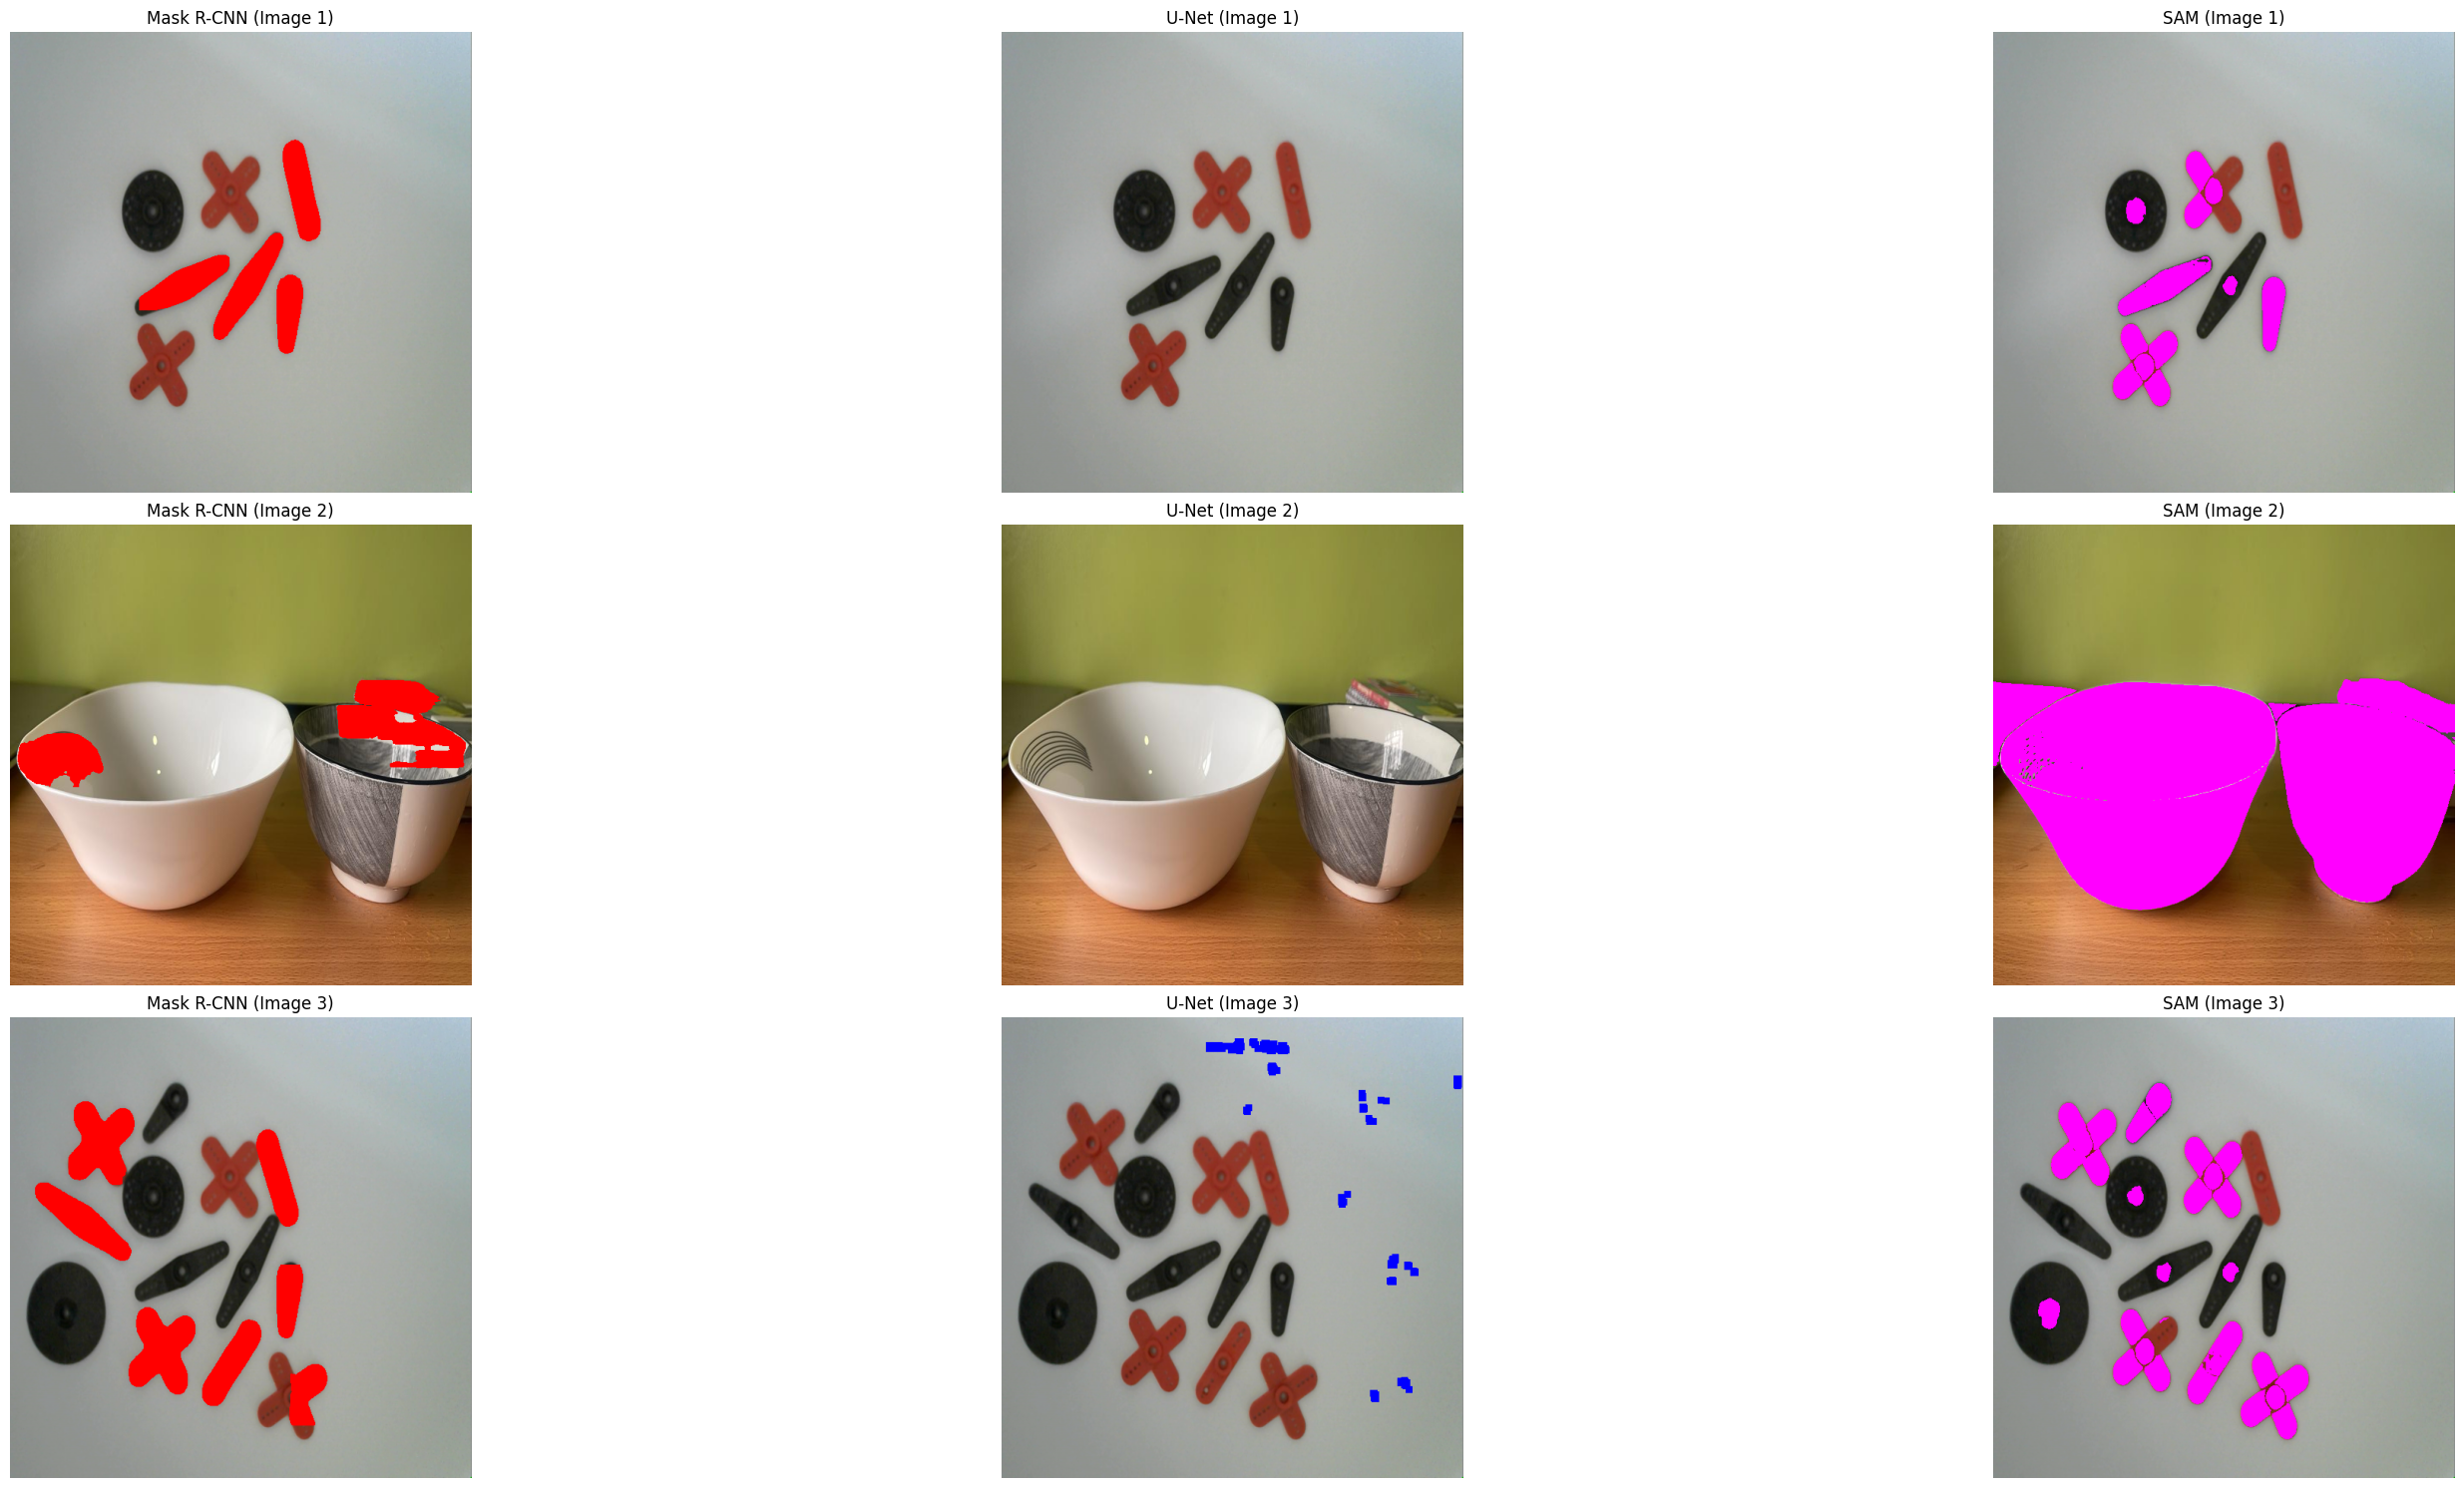

In [24]:
# Visualize the segmented objects with different colors
# Create a 3x5 grid: 3 rows (one for each image), 5 columns (one for each model)
plt.figure(figsize=(25, 15))

# List of original images and masks for each model
original_imgs = [original_img1, original_img2, original_img3]
maskrcnn_masks = [maskrcnn_final_mask1, maskrcnn_final_mask2, maskrcnn_final_mask3]
unet_masks = [unet_final_mask1, unet_final_mask2, unet_final_mask3]
sam_masks = [sam_final_mask1, sam_final_mask2, sam_final_mask3]

# Plot for each image
for img_idx in range(3):
    # Mask R-CNN
    plt.subplot(3, 5, img_idx * 5 + 1)
    maskrcnn_colored = original_imgs[img_idx].copy()
    maskrcnn_colored = cv2.resize(maskrcnn_colored, (608, 608))
    if np.any(maskrcnn_masks[img_idx]):
        maskrcnn_colored[maskrcnn_masks[img_idx] == 1] = [255, 0, 0]  # Red for mints
    plt.imshow(maskrcnn_colored)
    plt.title(f"Mask R-CNN (Image {img_idx + 1})")
    plt.axis("off")

    # U-Net
    plt.subplot(3, 5, img_idx * 5 + 3)
    unet_colored = original_imgs[img_idx].copy()
    unet_colored = cv2.resize(unet_colored, (608, 608))
    if np.any(unet_masks[img_idx]):
        unet_colored[unet_masks[img_idx] == 1] = [0, 0, 255]  # Blue for mints
    plt.imshow(unet_colored)
    plt.title(f"U-Net (Image {img_idx + 1})")
    plt.axis("off")

    # SAM
    plt.subplot(3, 5, img_idx * 5 + 5)
    sam_colored = original_imgs[img_idx].copy()
    sam_colored = cv2.resize(sam_colored, (608, 608))
    if np.any(sam_masks[img_idx]):
        sam_colored[sam_masks[img_idx] == 1] = [255, 0, 255]  # Purple for mints
    plt.imshow(sam_colored)
    plt.title(f"SAM (Image {img_idx + 1})")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Count segmented Objects

In [25]:
# Apply connected component analysis to count the segmented objects
# Count for each image and model
counts = {
    "Mask R-CNN": [],
    "U-Net": [],
    "SAM": []
}

# Mask R-CNN counts
for idx, mask in enumerate(maskrcnn_masks, 1):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    count = len(contours)
    counts["Mask R-CNN"].append(count)
    print(f"Mask R-CNN found {count} objects in image {idx}")

# U-Net counts
for idx, mask in enumerate(unet_masks, 1):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    count = len(contours)
    counts["U-Net"].append(count)
    print(f"U-Net found {count} objects in image {idx}")

# SAM counts
for idx, mask in enumerate(sam_masks, 1):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    count = len(contours)
    counts["SAM"].append(count)
    print(f"SAM found {count} objects in image {idx}")


Mask R-CNN found 4 objects in image 1
Mask R-CNN found 2 objects in image 2
Mask R-CNN found 7 objects in image 3
U-Net found 0 objects in image 1
U-Net found 0 objects in image 2
U-Net found 15 objects in image 3
SAM found 9 objects in image 1
SAM found 3 objects in image 2
SAM found 15 objects in image 3
